$$
r_i^1 = (P_{i+1}-P_i) / P_i = P_{i+1}/P_i - 1 \\
P_{i+1}/P_i = r_i^1 + 1 \\

r_{i+1}^1 = (P_{i+2}-P_{i+1}) / P_{i+1} = P_{i+2}/P_{i+1} - 1 \\
P_{i+2} = (r_{i+1}^1 + 1) P_{i+1} \\
r_i^2 = (P_{i+2}-P_i) / P_i = P_{i+2}/P_i - 1 = (r_{i+1}^1 + 1) P_{i+1}/P_i - 1 = (r_{i+1}^1 + 1) (r_i^1 + 1) - 1 \\
... \\
r_{i+n-1}^1 = (P_{i+n}-P_{i+n-1}) / P_{i+n-1} = P_{i+n}/P_{i+n-1} - 1 \\
P_{i+n} = (r_{i+n-1}^1 + 1) P_{i+n-1} \\
... \\
r_i^n = (P_{i+n}-P_i) / P_i = P_{i+n}/P_i - 1 = (r_{i+n-1}^1 + 1) P_{i+n-1}/P_i - 1 = \\
= (r_{i+n-1}^1 + 1)(r_{i+n-2}^1 + 1) P_{i+n-2}/P_i - 1 = \\
= (r_{i+n-1}^1 + 1)(r_{i+n-2}^1 + 1)...(r_{i+1}^1 + 1)(r_i^1 + 1) - 1 = \\
= -1+\prod_{j=0}^{n-1}(r_{i+j}^1 + 1) \\
$$

$r_i^1$ are sampled from $X$.
$$
X \sim \mathrm{Stable}(\alpha=1.7,\beta=0,c=1,\mu=1), \text{ where } c=\gamma,\,\mu=\delta \\
r_i^{10} = -1+\prod_{j=0}^{10-1}(r_{i+j}^1 + 1) \\
$$
$$
P(r^{10} \le r_{0.01}) \ge 0.01 \\
P(r^{10} \ge r_{0.01}) \le 1-0.01 \\
r_{0.01} =\, ? \text{ (target quantile to compute with MC simulation) }
$$
$$
Z \sim \mathcal{N}(\mu=0,\sigma=1), \\
P(|Z| > z_{0.95}) = 1 - 0.95 \\
P(Z < -z_{0.95}) = (1 - 0.95) / 2 \\
z_{0.95} =\, ? \text{ (auxiliary quantile for MC simulation) }
$$

In [6]:
"""
base outline of the algorithm:
in a loop:
  sample 750 random 1-returns
  convert to 740 10-returns
  compute 1%-percentile
  add 1%-percentile to a set
  compute mean and standard dev. estimates of the set
    and use them to check if Monte Carlo simulation should stop
  exit loop if stop
"""
from typing import Callable, List, NamedTuple, Tuple, Any, Dict
import math
import numpy as np
from numpy.typing import NDArray as Array
from scipy import stats


def to_debug_print(ntuple: tuple) -> tuple:
    """
    Clears fields of named tuple ``ntuple`` set in ``noprint_`` field typed ``Dict[str, Any]``
    (clears together with ``noprint_`` field).
    """
    if not hasattr(ntuple, 'noprint_') or not hasattr(ntuple, '_asdict'):
        return ntuple
    # noinspection PyProtectedMember,PyUnresolvedReferences
    dic = ntuple._asdict()
    noprint = getattr(ntuple, 'noprint_')
    assert isinstance(noprint, dict) and isinstance(dic, dict)
    noprint_, dic_ = noprint, dic
    for key in noprint_.keys():
        default_val = noprint_[key]
        dic_[key] = default_val
    dic_['noprint_'] = ()
    return type(ntuple)(**dic_)


def sample_1_day_returns(n_samples=750, alpha=1.7, beta=0., c=1., mu=1.) -> Array:
    """
    Samples from Stable distribution to simulate 1-day returns.
        https://en.wikipedia.org/wiki/Stable_distribution
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levy_stable.html

    :returns: samples of 1-day returns
    """
    r1 = stats.levy_stable.rvs(alpha=alpha, beta=beta, loc=mu, scale=c, size=n_samples)
    return r1


def n_day_returns(r1: Array, n: int=10) -> Array:
    """
    Converts 1-day returns samples to n-day returns samples.

    R_i^n = -1 + \\prod_{j=0}^{n-1}(R_{i+j}^1 + 1), where R_i^1 - 1-day returns, R_i^n - n-day returns.

    Rᵢⁿ = -1 + ∏ⱼ₌₀ⁿ⁻¹(Rᵢ₊ⱼ¹ + 1)

    :param r1: 1-day returns samples
    :param n: n days
    :returns: n-day returns samples
    """
    assert n >= 2
    r1plus1 = r1 + 1.

    j, k = 0, n - 1
    ret = np.copy(r1plus1[j:-k + j])
    for j in range(1, k):
        ret *= r1plus1[j:-k + j]
    j = k
    ret *= r1plus1[j:]

    r_n = ret - 1.
    return r_n


def get_samples_of_10_day_returns() -> Tuple[Array, tuple]:
    """ Samples 10 day returns"""
    return n_day_returns(sample_1_day_returns(), n=10), ('10-day-returns',)


def plot_distribution(sample: Array, local_bins=150, qmin=0.01, qmax=0.9999, xlabel: str='samples',
                      figsize=(6., 4.5), bars: Tuple[float, ...]=None, bars_legend: str=None) -> None:
    """
    Plots probability density histogram and Cumulative distribution histogram
    of the sample (convenient for the tailed dists).

    :param sample: sample from dist
    :param local_bins: estimate of bins in the [x_qmin, x_qmax] area
    :param qmin: quantile that sets xlim start
    :param qmax: quantile that sets xlim end
    :param xlabel:
    :param figsize:
    :param bars: vertical bars to plot
    :param bars_legend:
    """
    import matplotlib.pyplot as plt
    qmin_, qmax_ = np.quantile(sample, qmin), np.quantile(sample, qmax)
    min_, max_ = np.min(sample), np.max(sample)
    bins = round((max_ - min_) / (qmax_ - qmin_) * local_bins)

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(2 * figsize[0], figsize[1]))

    ax0.hist(sample, bins=bins, density=True)
    ax0.set_xlim(qmin_, qmax_)
    ax0.set_xlabel(xlabel)
    ax0.set_ylabel('Probability density histogram')
    ax0.set_title(f'X-axis is plotted from {qmin}-quantile to {qmax}-quantile\n'
                  + f'omitted values: min={round(min_)}, max={round(max_)}', loc='right')
    if bars is not None:
        for i, bar in enumerate(bars):
            ax0.axvline(x=bar, color='orange', **(dict(label=bars_legend) if i == 0 else {}))
        ax0.legend()

    ax1.hist(sample, bins=bins, density=True, cumulative=True)
    ax1.set_xlim(qmin_, qmax_)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Cumulative distribution histogram')
    ax1.set_title(f'X-axis is plotted from {qmin}-quantile to {qmax}-quantile\n'
                  + f'omitted values: min={round(min_)}, max={round(max_)}', loc='right')
    if bars is not None:
        for i, bar in enumerate(bars):
            ax1.axvline(x=bar, color='orange', **(dict(label=bars_legend) if i == 0 else {}))
        ax1.legend()

    plt.tight_layout()
    plt.show()


class ReturnRepresntv(NamedTuple):
    """ See ``check_representativeness`` for details. Shape of ``d_pval`` is ``(n_tests, 2)``. """
    n_above_ks2_thr: int
    ks2_thr: float
    n_reject: int
    n_tests: int
    level: float
    d_pval: List[List[float]]
    noprint_: Dict[str, Any] = dict(d_pval=())


def check_representativeness(samples: Array, n_tests=100, level=0.1, ks2_thr=0.02) -> Tuple[bool, ReturnRepresntv]:
    """
    Using Two-sample Kolmogorov–Smirnov test checks if the sample is representative.
    Is based on https://stats.stackexchange.com/a/97552
    and https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html

    Main assumption is that if we ``n_tests`` times randomly partition ``samples`` into
    two subsamples of approximately equal sizes and each time two subsamples pass
    Kolmogorov–Smirnov test then we decide that original ``samples`` are representative.
    This is ad hock solution as Kolmogorov–Smirnov test is the only test I found in the
    context of checks if the sample is representative (unfortunately it was applied to
    different situations).

    Main criteria is setting threshold for Two-sample Kolmogorov–Smirnov test's ``D`` value.
    Setting it you can select desired smoothness of the generated distribution.

    pvalues returned by scipy are only used in ad-hockish way to make sure that distribution of
    ``D`` from ``n_tests`` partition tests follows two-sided Kolmogorov-Smirnov statistic.
    I only check ``soft_level``-quantile a bit.

    -----------------------------------------------------------------------------------

    From doi:10.1007/bf02589501 :
    P_i = Pr(D >= d | F = G),
    where D = sup_u|F_m(u) - G_n(u)| = D_{n,m},
    where m samples are from F and n samples are from G.
    P_1 and P_2 correspond to one-sided and two-sided cases respectively.

    ``scipy.stats.kstest`` returns (D, pvalue).
    pvalue = P_i = Pr(D >= d | F = G) ~= 1 - KS2(D; (n + m) / (n * m) ),
    where KS2 - CDF for the two-sided Kolmogorov-Smirnov statistic.

    -----------------------------------------------------------------------------------

    If pvalue is lower than selected significance level (e.g. 0.01) then null hypothesis
    (of equality of distributions) is rejected (pvalue < 0.01 means that probability to
    get our obtained D statistic when F = G is < 0.01). If we run
    ``scipy.stats.kstest(np.random.normal(0, 1, 100000), 'norm')`` several times we soon
    would encounter pvalue < 0.01. But most of the values would be high enough.

    Actually in practice when F = G if we select significance level as 0.1 then approximately
    10% of partition checks pvalues be below 0.1. Same is for 0.2. That is correct as
    when F = G the distribution of D follows statistic from which pvalues are taken.

    :param samples: samples
    :param n_tests: number of splits-in-two of samples on which
        the Two-sample Kolmogorov–Smirnov (KS2) test is performed.
    :param level: significance level. There should be no more KS2-tests where
        pvalues < soft_level than soft_level part (portion) of n_tests.
    :param ks2_thr: threshold that KS2 D statistic should be below
    :returns: success, ReturnRepresntv(...)
    """
    d_pval: List[List[float]] = []
    for _ in range(n_tests):
        rnd_mask = np.random.choice([True, False], size=len(samples), p=[0.5, 0.5])
        d, pvalue = stats.kstest(samples[rnd_mask], samples[~rnd_mask])
        d_pval.append([d, pvalue])
    pvals = np.array(d_pval)[:, 1]
    ds = np.array(d_pval)[:, 0]
    n_reject = len(pvals[pvals <= level])
    n_above_ks2_thr = len(ds[ds > ks2_thr])

    return (
        ((n_reject / n_tests) < level) and (n_above_ks2_thr == 0),
        ReturnRepresntv(n_above_ks2_thr=n_above_ks2_thr, ks2_thr=ks2_thr, n_reject=n_reject, n_tests=n_tests,
                        level=level, d_pval=d_pval)
    )


class ReturnMCCompQ(NamedTuple):
    mu: float
    success: bool
    target_accuracy: float
    real_accuracy: float
    abs_accuracy: bool
    ci_prob: float
    quantile: float
    n: int
    mu_ci: Tuple[float, float]
    sampler_info: tuple


def mc_compute_quantile(sampler: Callable[[], Tuple[Array, tuple]]=get_samples_of_10_day_returns,
                        quantile: float=0.01, ci_prob: float=0.95, accuracy: float=0.01,
                        abs_accuracy: float=None, n_trials_max: int=10**10, n_trials_min=100) -> Tuple[ReturnMCCompQ,
                                                                                                       List[float]]:
    """
    Using Monte Carlo Simulation computes ``quantile`` of a distribution that is set by ``sampler``.

    ``quantile`` estimation is based on https://quant.stackexchange.com/a/21769
    Algorithm stops when limit of mean value of trials is estimated to be in the confidence interval:

    ``| real_mean - estimated_mean | < (abs_accuracy if abs_accuracy else accuracy * |estimated_mean|)``.

    Returns estimated quantile (via mean value of trials) together with estimated error
    and all quantile-trials calculated.

    :param sampler: callable that returns random samples to compute quantile from (and sampler info)
    :param quantile: quantile to compute
    :param ci_prob: probability that computed quantile is within the confidence interval
    :param accuracy: relative accuracy (on check it is multiplied on estimated mean)
    :param abs_accuracy: if set use absolute accuracy instead of the relative one
    :param n_trials_max: maximum number of Monte Carlo trials
    :param n_trials_min: minimum number of Monte Carlo trials
    :return: ReturnMCCompQ(...), q_samples
    """
    assert (n_trials_min >= 30) and (ci_prob > 0)
    # abs value of CI quantile (like 0.95 => 1.96):
    ci_q = abs(float(stats.norm.ppf(q=(1 - ci_prob) / 2, loc=0, scale=1)))
    accuracy_ = abs_accuracy if (abs_accuracy is not None) else accuracy
    abs_accuracy_ = bool(abs_accuracy is not None)

    def check_mu_accuracy(mu_: float, sigma2_: float, n_: int):
        return ci_q * math.sqrt(sigma2_ / n_) / (1 if abs_accuracy_ else abs(mu_))

    q_samples: List[float] = []  # quantile samples
    sampler_info = ''
    for i in range(n_trials_min):
        smpl, sampler_info = sampler()
        q_samples.append(float(np.quantile(smpl, quantile)))

    n = n_trials_min
    q_samples_ = np.array(q_samples)
    # mean estimation of quantile samples:
    mu = float(np.sum(q_samples_) / n)
    # squared standard deviation estimation of quantile samples:
    sigma2 = float(np.sum(np.square(q_samples_ - mu)) / (n - 1))

    for i in range(n_trials_max - n_trials_min):
        smpl, sampler_info = sampler()
        q = float(np.quantile(smpl, quantile))
        q_samples.append(q)

        mu_next = mu + (q - mu) / (n + 1)
        sigma2: float = (1 - 1 / n) * sigma2 + (n + 1) * (mu_next - mu)**2

        mu = mu_next
        n += 1

        if check_mu_accuracy(mu, sigma2, n) < accuracy_:
            success = True
            break

    else:  # max limit of trials was exceeded
        success = False

    real_accuracy = check_mu_accuracy(mu, sigma2, n)
    abs_real_accuracy = real_accuracy * abs(mu) if not abs_accuracy_ else real_accuracy
    mu_ci = mu - abs_real_accuracy, mu + abs_real_accuracy
    return ReturnMCCompQ(mu=mu, success=success,
                         target_accuracy=accuracy_, real_accuracy=real_accuracy,
                         abs_accuracy=abs_accuracy_, ci_prob=ci_prob, quantile=quantile, n=n, mu_ci=mu_ci,
                         sampler_info=sampler_info), q_samples


class ReturnMCGenQ(NamedTuple):
    mu: float
    success: bool
    quantile: float
    n: int
    sampler_info: tuple
    represntv_return: tuple


def mc_generate_quantile_dist(sampler: Callable[[], Tuple[Array, tuple]]=get_samples_of_10_day_returns,
                              quantile: float=0.01, n_trials_max: int=10**10, n_trials_min=50,
                              represntv_checker: Callable[[Array], Tuple[bool, tuple]]=check_representativeness,
                              represntv_check_freq: int=500):
    """
    Using Monte Carlo Simulation generates distribution of ``quantile`` approximations
    of a distribution that is set by ``sampler``.
    Performs representativeness checks every ``repres_check_freq`` iterations and stops when the check pass
    (as I have no idea except representativeness as a criteria to stop MC simulation which goal
    is to generate a distribution).

    Returns representativeness check output and quantile-trials calculated.

    :param sampler: callable that returns random samples to compute quantile from (and sampler info).
    :param quantile: quantile to compute
    :param n_trials_max: maximum number of Monte Carlo trials
    :param n_trials_min: minimum number of Monte Carlo trials
    :param represntv_checker: callable that performs representativeness checks. Returns bool and info.
    :param represntv_check_freq: representativeness checks frequency
    :return: ReturnMCGenQ(...), q_samples
    """
    assert n_trials_min >= 30

    q_samples: List[float] = []  # quantile samples
    sampler_info, repr_ret = '', ()
    for i in range(n_trials_min):
        smpl, sampler_info = sampler()
        q_samples.append(float(np.quantile(smpl, quantile)))

    n = n_trials_min
    q_samples_ = np.array(q_samples)
    # mean estimation of quantile samples:
    mu = float(np.sum(q_samples_) / n)

    for i in range(n_trials_max - n_trials_min):
        smpl, sampler_info = sampler()
        q = float(np.quantile(smpl, quantile))
        q_samples.append(q)

        mu_next = mu + (q - mu) / (n + 1)
        mu = mu_next
        n += 1

        if n % represntv_check_freq == 0:
            success, repr_ret = represntv_checker(np.array(q_samples))
            print(n, success, to_debug_print(repr_ret))
            if success:
                break

    else:  # max limit of trials was exceeded
        success = False

    return ReturnMCGenQ(mu=mu, success=success, quantile=quantile, n=n,
                        sampler_info=sampler_info, represntv_return=repr_ret), q_samples

In [7]:
ret2, quantile_samples2 = mc_generate_quantile_dist()
print(ret2)

500 False ReturnRepresntv(n_above_ks2_thr=100, ks2_thr=0.02, n_reject=13, n_tests=100, level=0.1, d_pval=(), noprint_=())
1000 False ReturnRepresntv(n_above_ks2_thr=100, ks2_thr=0.02, n_reject=12, n_tests=100, level=0.1, d_pval=(), noprint_=())
1500 False ReturnRepresntv(n_above_ks2_thr=98, ks2_thr=0.02, n_reject=13, n_tests=100, level=0.1, d_pval=(), noprint_=())
2000 False ReturnRepresntv(n_above_ks2_thr=99, ks2_thr=0.02, n_reject=12, n_tests=100, level=0.1, d_pval=(), noprint_=())
2500 False ReturnRepresntv(n_above_ks2_thr=96, ks2_thr=0.02, n_reject=10, n_tests=100, level=0.1, d_pval=(), noprint_=())
3000 False ReturnRepresntv(n_above_ks2_thr=91, ks2_thr=0.02, n_reject=11, n_tests=100, level=0.1, d_pval=(), noprint_=())
3500 False ReturnRepresntv(n_above_ks2_thr=79, ks2_thr=0.02, n_reject=8, n_tests=100, level=0.1, d_pval=(), noprint_=())
4000 False ReturnRepresntv(n_above_ks2_thr=74, ks2_thr=0.02, n_reject=12, n_tests=100, level=0.1, d_pval=(), noprint_=())
4500 False ReturnRepresn

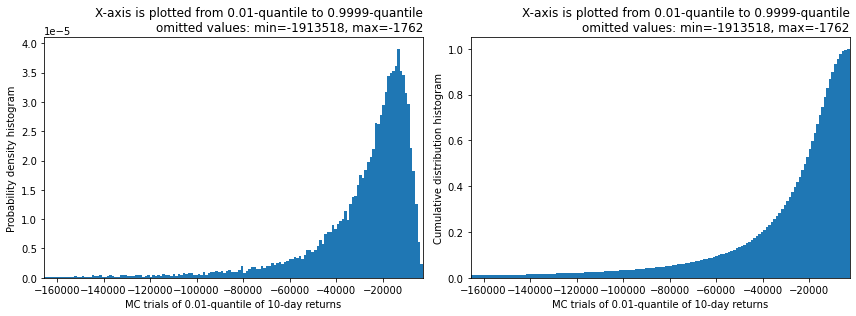

In [8]:
quantile_samples_2 = np.array(quantile_samples2)
plot_distribution(quantile_samples_2, xlabel=f'MC trials of {ret2.quantile}-quantile of 10-day returns')

In [9]:
ret1, quantile_samples1 = mc_compute_quantile()
print(ret1)

ReturnMCCompQ(mu=-30927.52893294526, success=True, target_accuracy=0.01, real_accuracy=0.009999914692305984, abs_accuracy=False, ci_prob=0.95, quantile=0.01, n=133608, mu_ci=(-31236.80158391854, -30618.256281971982), sampler_info=('10-day-returns',))


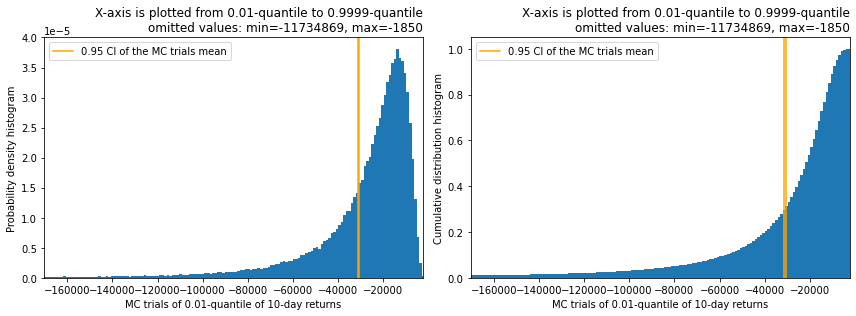

In [10]:
quantile_samples_1 = np.array(quantile_samples1)
plot_distribution(quantile_samples_1, xlabel=f'MC trials of {ret1.quantile}-quantile of 10-day returns',
                  bars=ret1.mu_ci, bars_legend=f'{ret1.ci_prob} CI of the MC trials mean')